# Windy gridworld with $n$-step SARSA

The target for for $n$-step SARSA is

$$
    y(s,a) = \sum_{k=1}^n \gamma^{k-1}\,r_{t+n} + \gamma^n Q(s_{t+n}, a_{t+n}).
$$

The update takes the form
$$
    Q(s, a) = Q(s, a) + \alpha\,[y(s,a) - Q(s,a)]
$$

In [1]:
from tabrl import agents, gridworld

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numba import njit
from itertools import product

In [3]:
%config InlineBackend.figure_format = "retina"
sns.set_palette("colorblind")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
markers = {
    "down": "v",
    "up": "^",
    "right": ">",
    "left": "<",
    "nothing": "o"
}

def plot_gridworld_run(ax, run, ix_hist, action_hist, reward_hist, G):
    ix_goal = np.where(reward_hist == G.reward_goal)[0]
    pos_hist = np.c_[ix_hist % n_cols, ix_hist // n_cols]

    iinit = ix_goal[run] 
    iend = ix_goal[run + 1]
    
    subhist_action = action_hist[iinit:iend]
    subhist_action = [name_movements[int(action)] for action in subhist_action]
    subhist_action = [markers[action] for action in subhist_action]
    
    subhist_pos = pos_hist[iinit:iend]
    
    
    plt.plot(*subhist_pos.T, c="black", linestyle="--")
    
    for (x,y), m in zip(subhist_pos, subhist_action):
        plt.scatter(x, y, marker=m, zorder=3, s=50, c="crimson")
    
    xticks = np.arange(n_cols)
    yticks = np.arange(n_rows)
    ax.set(
        xticks=xticks + 0.5,
        yticks=yticks + 0.5,
        xticklabels="",
        yticklabels="",
    )
    ax.set_xticks(xticks, labels=xticks, minor=True)
    ax.set_yticks(yticks, labels=yticks, minor=True)
    
    # ax.scatter(*pos_hist[iinit], marker="$S$", s=100, zorder=3)
    # ax.scatter(*pos_hist[iend-1], marker="$G$", s =100, c="crimson", zorder=3)
    ax.set_ylim(-0.5, n_rows - 0.5)
    ax.set_xlim(-0.5, n_cols - 0.5)
    ax.invert_yaxis()
    
    
    for i, (r, c) in enumerate(product(range(G.n_rows), range(G.n_cols))):
        plt.text(c, r, i, c="tab:gray", zorder=0, fontsize=6)
    
    plt.grid(alpha=0.3)

## Gridworld

In [6]:
n_rows = 7
n_cols = 10

In [7]:
movements = np.array([
    [0, 1], # right   (0)
    [0, -1], # left   (1)
    [1, 0], # down,   (2)
    [-1, 0], # up     (3)
    [0, 0], # nothing (4)
])
n_actions = len(movements)

name_movements = ["right", "left", "down", "up"]
name_movements = ["right", "left", "down", "up", "nothing"]

In [8]:
start_ix = 30
end_ix = 37
reward_goal =  20
G = gridworld.WindyGridworld(start_ix, end_ix, n_rows, n_cols, reward_goal)

In [9]:
G.map_ix

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]], dtype=int32)

In [10]:
def plot_grid(ax, G):
    xticks = np.arange(G.n_cols)
    yticks = np.arange(G.n_rows)
    ax.set(
        xticks=xticks + 0.5,
        yticks=yticks + 0.5,
        xticklabels="",
        yticklabels="",
    )
    ax.set_xticks(xticks, labels=xticks, minor=True)
    ax.set_yticks(yticks, labels=yticks, minor=True)
    
    ax.set_ylim(-0.5, n_rows - 0.5)
    ax.set_xlim(-0.5, n_cols - 0.5)
    ax.invert_yaxis()
    
    
    for i, (r, c) in enumerate(product(range(G.n_rows), range(G.n_cols))):
        plt.text(c, r, i, c="tab:gray", zorder=0, fontsize=6)
    
    plt.grid(alpha=0.3)

# $n$-step SARSA updates

In [11]:
@njit
def update_buffer(buffer, new_element):
    """
    Update buffer FIFO mode.
    We assume that elements in the buffer are time-ordered
    along the first axis.

    Parameters
    ----------
    buffer: np.array
        (B, ...)
    new_element: np.array
        (...,)
    """
    buffer = np.roll(buffer, -1)
    buffer[-1] = new_element
    return buffer


@njit
def nstep_sarsa_buffer_update(
    buffers, Q, alpha, gamma, end_state_reached
):
    """
    N-step SARSA update for episodic task with replay-buffer exhaustion
    """
    buffer_states, buffer_actions, buffer_rewards = buffers
    
    # 4.1 Update the Q-values using n-step sarsa
    if not end_state_reached:
        Q = agents.nstep_sarsa_update(
            buffer_states, buffer_actions, buffer_rewards, Q, alpha, gamma, end_state_reached
        )
    
    # 4.2. Update the Q-values MC-style, i.e., we do not bootstrap
    else:
        for b in np.arange(buffer_size):
            Q = agents.nstep_sarsa_update(
                buffer_states, buffer_actions, buffer_rewards, Q, alpha, gamma, end_state_reached
            )
    
            # Flush oldest element from buffers
            buffer_actions = update_buffer(buffer_actions, np.nan)
            buffer_states = update_buffer(buffer_states, np.nan)
            buffer_rewards = update_buffer(buffer_rewards, np.nan)

            # Stop updating if the number of rewards in the buffer
            # is less than the total reward.
            if np.isnan(buffer_rewards).all():
                break

    buffers = buffer_states, buffer_actions, buffer_rewards
    return Q, buffers


@njit
def buffers_init(buffer_size):
    buffer_actions = np.zeros(buffer_size + 1) * np.nan
    buffer_states = np.zeros(buffer_size + 1) * np.nan
    buffer_rewards = np.zeros(buffer_size) * np.nan

    buffers = (buffer_states, buffer_actions, buffer_rewards)
    return buffers


@njit
def update_buffers_mdp(buffers, state, action, reward):
    """
    Update Markvov decision process' buffers: state, action, rewards 
    """

    buffer_state, buffer_action, buffer_rewards =  buffers

    buffer_state = update_buffer(buffer_state, state)
    buffer_action = update_buffer(buffer_action, action)
    buffer_rewards = update_buffer(buffer_rewards, reward)

    buffers = (buffer_state, buffer_action, buffer_rewards)

    return buffers

@njit
def is_valid_update_step(ix, G, buffers) -> bool:
    """
    Determine whether the current step should be updated

    TODO: FIX.
    """
    buffer_rewards = buffers[-1]
    
    is_buffer_full = not np.isnan(buffer_rewards).any()
    end_state_reached = (ix == G.ix_goal)

    result = not(is_buffer_full or end_state_reached)

    return result, end_state_reached

@njit
def update_history_mdp(t, hist_mdp, state, action, reward):
    hist_state, hist_action, hist_reward = hist_mdp
    hist_state = np.copy(hist_state)
    hist_action = np.copy(hist_action)
    hist_reward = np.copy(hist_reward)

    hist_state[t] = state
    hist_action[t] = action
    hist_reward[t] = reward

    hist_mdp = (hist_state, hist_action, hist_reward)
    return hist_mdp

@njit
def init_hist_mdp(n_steps):
    ix_hist = np.empty(n_steps)
    action_hist = np.empty(n_steps)
    reward_hist = np.empty(n_steps)
    hist_mdp = (ix_hist, action_hist, reward_hist)
    
    return hist_mdp

@njit
def init_action_value_function(G, n_actions):
    return np.zeros((G.n_rows * G.n_cols, n_actions))

In [12]:
base_seed = 314
n_steps = 10_000
epsilon = 0.01
alpha = 0.5
gamma = 1.0
buffer_size = 15

In [13]:
# Initialise action-value function
Q = init_action_value_function(G, n_actions)

# Initialise state and take an action
agents.set_seed(base_seed - 1)
ix = start_ix
action = agents.choose_action(ix, Q, epsilon)

hist_mdp = init_hist_mdp(n_steps)
hist_mdp = update_history_mdp(0, hist_mdp, ix, action, 0)

buffers_mdp = buffers_init(buffer_size)
buffers_mdp = update_buffers_mdp(buffers_mdp, ix, action, np.nan)

for t in range(n_steps):
    agents.set_seed(base_seed + t)

    # 1. take step, obtain reward and new state
    r, ix = G.step(ix, action, movements)

    # 2. Select the new action based on Q and the new state
    # epsilon-greedy style
    action = agents.choose_action(ix, Q, epsilon)

    # 3. Update states
    # 3.1 Update buffers:
    # insert newest (state/action/reward) and remove oldest (state/action/reward)
    buffers_mdp = update_buffers_mdp(buffers_mdp, ix, action, r)

    # 3.2 Update history
    hist_mdp = update_history_mdp(t, hist_mdp, ix, action, r)
    
    # 4 Continue interacting with the environment without updates until
    # the buffer is full or we reach an end state
    skip_update, end_state_reached = is_valid_update_step(ix, G, buffers_mdp)
    if skip_update:
        continue

    # 5. Make n-step update:
    #   Either n-step SARSA or Monte Carlo.
    Q, buffers_mdp = nstep_sarsa_buffer_update(buffers_mdp, Q, alpha, gamma, end_state_reached)

In [14]:
ix_hist, action_hist, reward_hist = hist_mdp

# ix_goal = np.where(ix_hist == G.ix_goal)[0]
ix_goal = np.where(reward_hist == G.reward_goal)[0]
pos_hist = np.c_[ix_hist % n_cols, ix_hist // n_cols]

n_runs = len(ix_goal)
n_runs

23

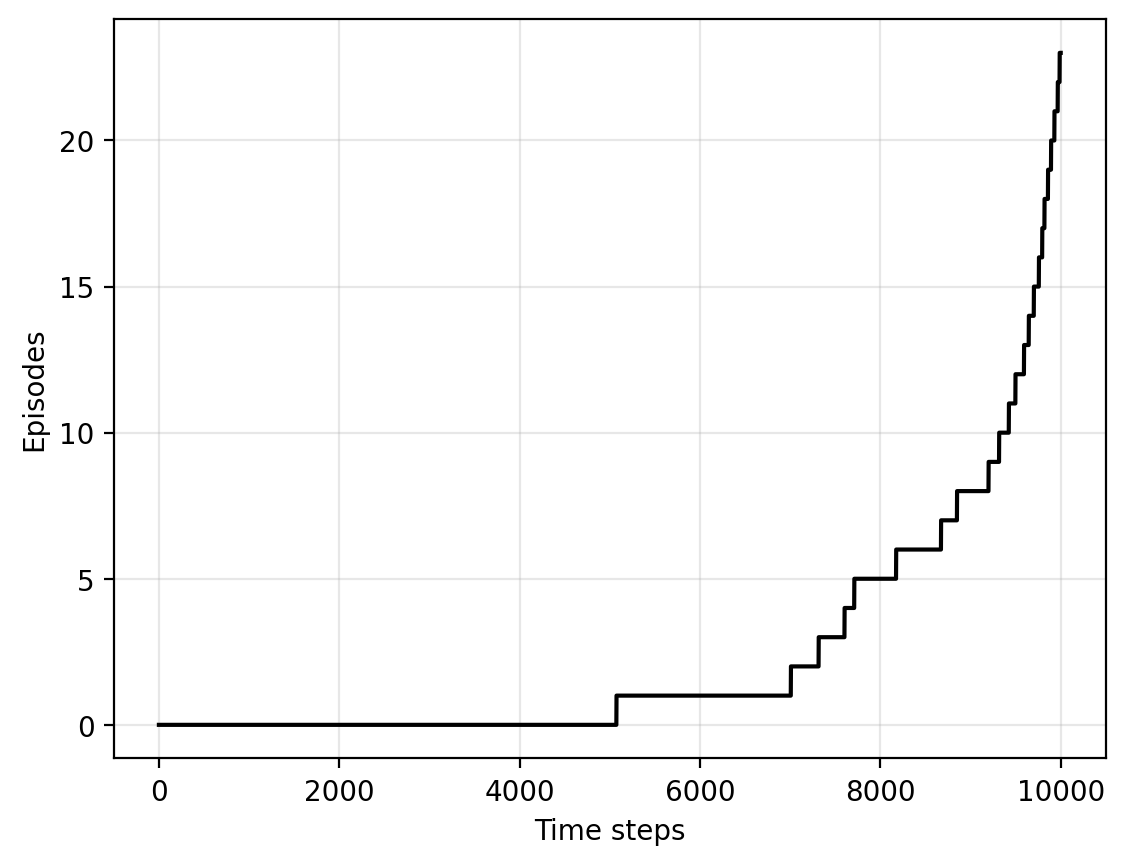

In [15]:
plt.plot((reward_hist == reward_goal).cumsum(), c="black")
plt.grid(alpha=0.3)
plt.xlabel("Time steps")
plt.ylabel("Episodes");

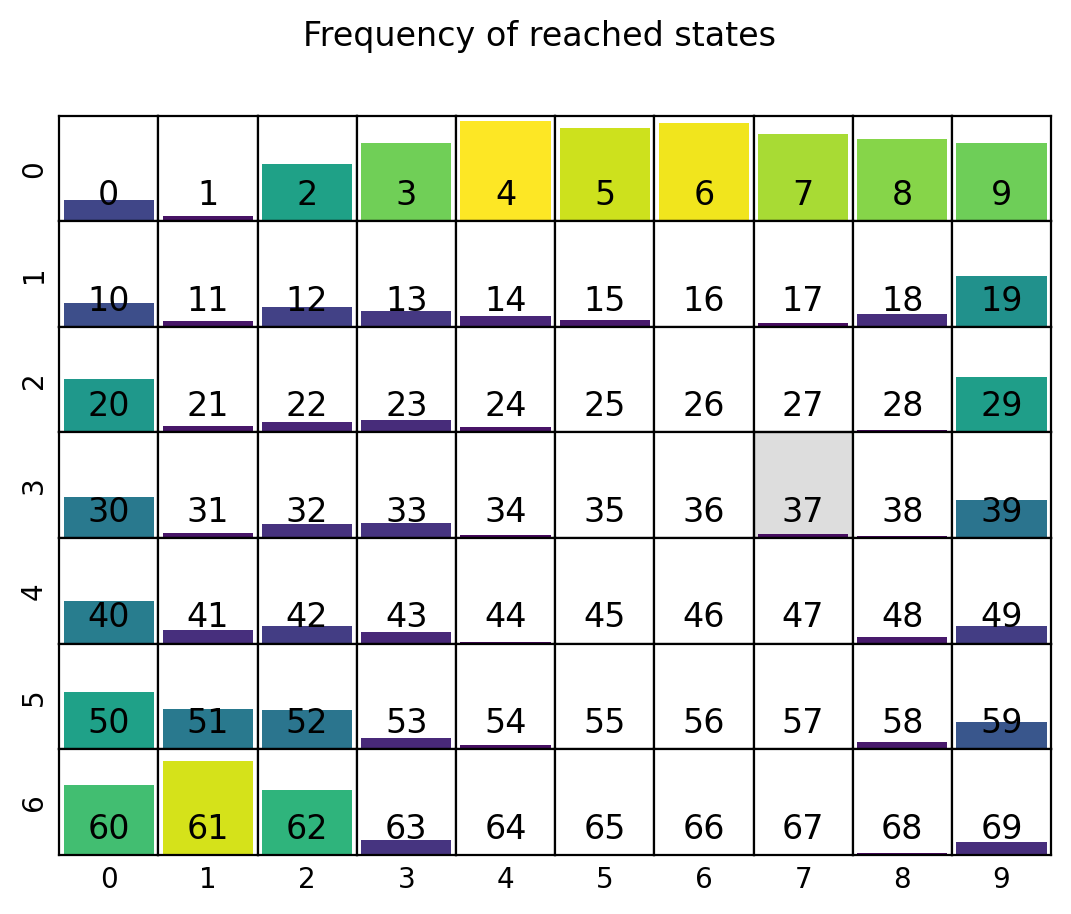

In [16]:
ix_freq = pd.Series(ix_hist).value_counts().sort_index()
ix_freq = ix_freq.reindex(np.arange(0, G.map_ix.max() + 1), fill_value=0)
colors = plt.cm.viridis((ix_freq.values - ix_freq.min()) / (ix_freq.max() - ix_freq.min()))

fig, axs = plt.subplots(nrows=7, ncols=10, figsize=(6.4 * 1.0, 4.8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for (ix, freq), color in zip(ix_freq.items(), colors):
    row = ix // G.n_cols
    col = ix % G.n_cols
    
    axi = axs[row, col]

    if ix == G.ix_goal:
        # color = "crimson"
        axi.set_facecolor("#AAAAAA66")
    
    axi.bar([0], [freq], color=color)
    axi.set_xticks([])
    axi.set_yticks([])
    axi.set_title(ix, y=0)

for n in range(G.n_rows):
    axs[n,0].set_ylabel(n)
    
for n in range(G.n_cols):
    axs[-1,n].set_xlabel(n)
    
plt.suptitle("Frequency of reached states");

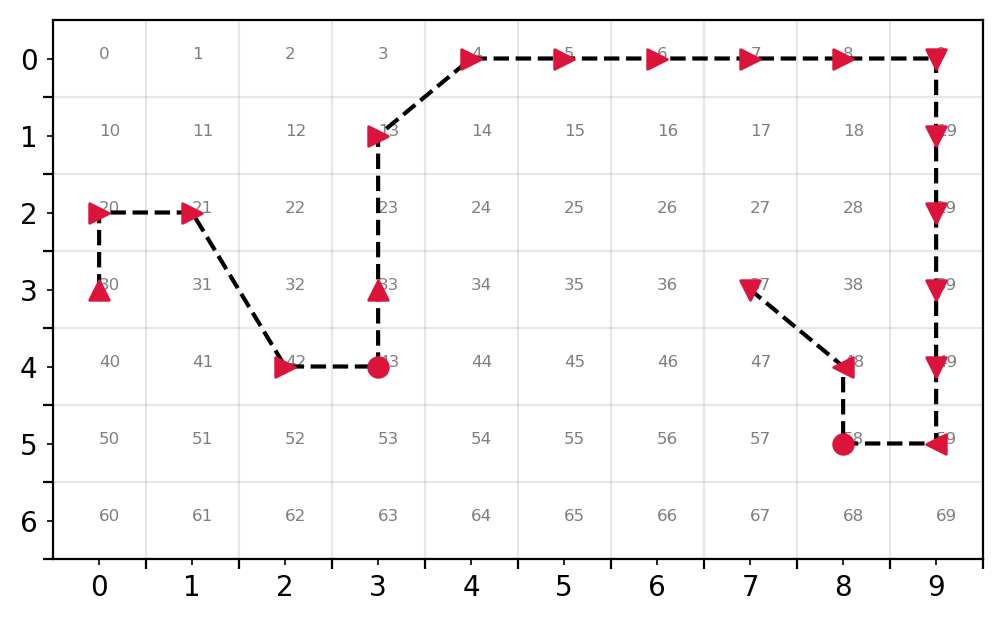

In [18]:
fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.5))

run = -2
plot_gridworld_run(ax, run, ix_hist, action_hist, reward_hist, G)

## Run $n$-step SARSA

In [91]:
@njit
def run_n_step_sarsa(G, n_actions, n_steps, alpha, gamma, buffer_size, base_seed=314):

    # Initialise action-value function
    Q = init_action_value_function(G, n_actions)
    
    # Initialise state and take an action
    agents.set_seed(base_seed - 1)
    ix = start_ix
    action = agents.choose_action(ix, Q, epsilon)
    
    hist_mdp = init_hist_mdp(n_steps)
    hist_mdp = update_history_mdp(0, hist_mdp, ix, action, 0)
    
    buffers_mdp = buffers_init(buffer_size)
    buffers_mdp = update_buffers_mdp(buffers_mdp, ix, action, np.nan)
    
    for t in range(n_steps):
        agents.set_seed(base_seed + t)
    
        # 1. take step, obtain reward and new state
        r, ix = G.step(ix, action, movements)
    
        # 2. Select the new action based on Q and the new state
        # epsilon-greedy style
        action = agents.choose_action(ix, Q, epsilon)
    
        # 3. Update states
        # 3.1 Update buffers:
        # insert newest (state/action/reward) and remove oldest (state/action/reward)
        buffers_mdp = update_buffers_mdp(buffers_mdp, ix, action, r)
    
        # 3.2 Update history
        hist_mdp = update_history_mdp(t, hist_mdp, ix, action, r)
        
        # 4 Continue interacting with the environment without updates until
        # the buffer is full or we reach an end state
        skip_update, end_state_reached = is_valid_update_step(ix, G, buffers_mdp)
        if skip_update:
            continue
    
        # 5. Make n-step update:
        #   Either n-step SARSA or Monte Carlo.
        Q, buffers_mdp = nstep_sarsa_buffer_update(buffers_mdp, Q, alpha, gamma, end_state_reached)

    return Q, hist_mdp

In [119]:
%%time
base_seed = 3141
n_steps = 30_000
epsilon = 0.01
alpha = 0.1 # 0.5 (for better performance with n=1)
gamma = 1.0

touches = {}
buffer_sizes = [1, 2, 3, 4, 5, 10, 15, 20, 25]
for buffer_size in buffer_sizes:
    Q, hist_mdp = run_n_step_sarsa(G, n_actions, n_steps, alpha, gamma, buffer_size, base_seed)
    ix_hist, action_hist, reward_hist = hist_mdp
    ix_goal = np.where(reward_hist == G.reward_goal)[0]
    goal_touches = reward_hist == reward_goal

    touches[buffer_size] = goal_touches

CPU times: user 3.2 s, sys: 351 ms, total: 3.55 s
Wall time: 3.55 s


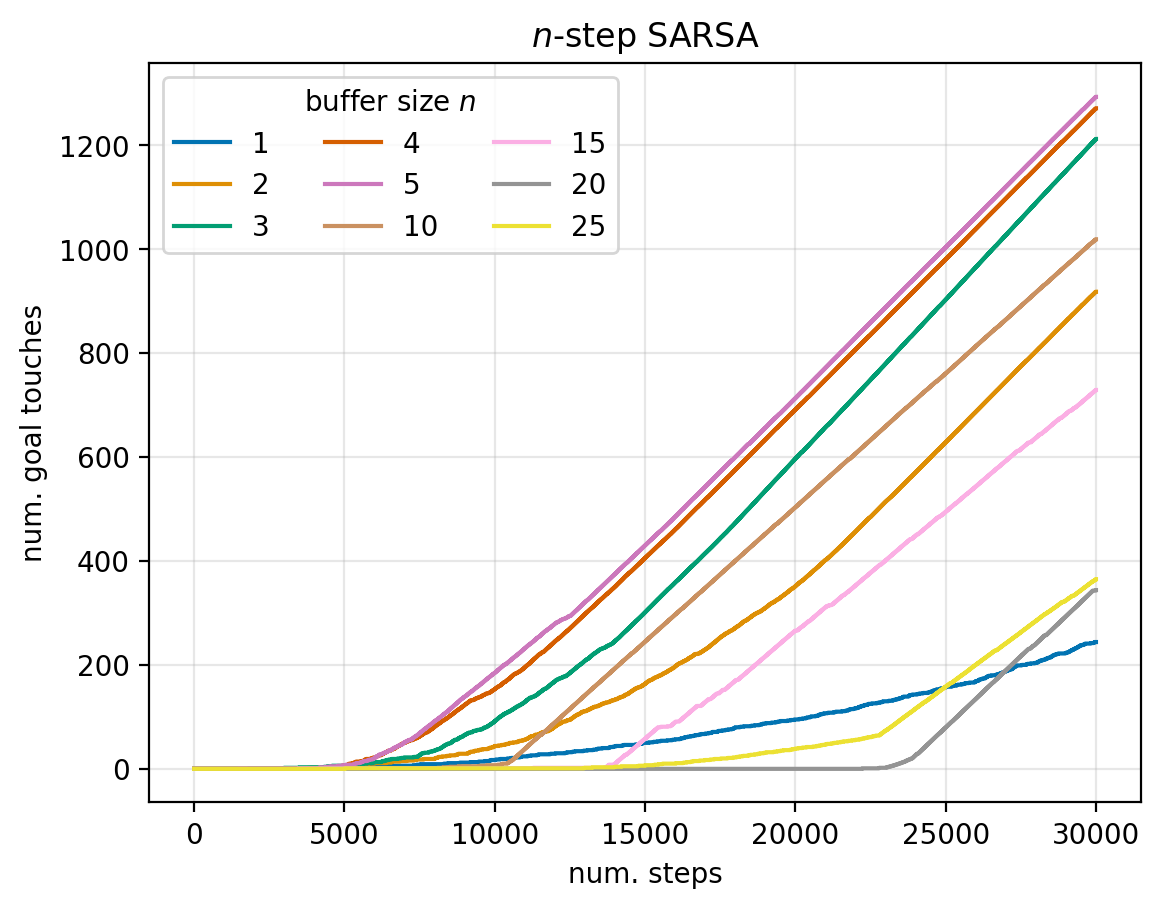

In [120]:
for buffer_size, goal_touches in touches.items():
    plt.plot(goal_touches.cumsum(), label=buffer_size)
plt.legend(ncol=3, title="buffer size $n$")
plt.xlabel("num. steps")
plt.ylabel("num. goal touches")
plt.title("$n$-step SARSA")
plt.grid(alpha=0.3)